# 0. Infos
Zweck: 
- Verarbeitung eines mit SimRobot erstellten Datensatzes
- Training eines Modells zur Erkennung und Lokalisierung eines einzelnen Naos

Author: David Kostka

Datum: 05.11.2020

Es werden einige Module verwendet von welchen hier nicht alle Funktionalitäten erklärt werden, daher bei unklarheiten einfach die Dokus anschauen:
- pandas: https://pandas.pydata.org/docs/
- numpy: https://numpy.org/doc/stable/index.html
- TensorFlow: https://www.tensorflow.org/guide
- tf.data: https://www.tensorflow.org/guide/data
- Keras: https://keras.io/getting_started/

# 1. Includes



In [1]:
import pandas as pd
import tensorflow as tf
print(tf.__version__)
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))
import numpy as np
from time import time

from tensorflow.keras.callbacks import (
    ReduceLROnPlateau,
    EarlyStopping,
    ModelCheckpoint,
    TensorBoard
)

# Eigene Module
import visual as vis
import util
import model as md
import tools.dataset as ds

2.3.1
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


ModuleNotFoundError: No module named 'model'

# 2. Definitions
Hier werden die Dateipfade und Namen definiert

In [ ]:
# Definitionen für selbst generierte Daten (Modelle, Graphen, ...)
models_path = '../data/models/'
model_name = 'single_nao_conf_test6'
logs_path = '../data/logs/'
chkpts_path = '../data/checkpoints/'
graphs_path = '../data/graphs/'
tables_path = '../data/tables/'

# Namen der Unterordner des Simulator Datasets ('1_1/', '1_2/', ..., '2_5/')
subfolders = []
for i in range(1, 3):
    for j in range(1, 6):
        subfolders.append(str(i) + '_' + str(j) + '/')

img_path = 'D:/workspace/datasets/simulator/1_1/images/'
csv_path = 'D:/workspace/datasets/simulator/1_1/labels.csv'
neg_csv_path = '../data/datasets/simulator/labels_with_negatives.csv'

# 3. Preprocessing

## 3.1 Create TF Records
Erstelle in jedem Unterordner des Datensatz eine TFRecord File für Train- und Validierungsdaten, in welcher jeder Eintrag ein Bilddateinamen und entsprechende Labels der Bildes enthält. 

Die Daten werden in 'train.record' und 'val.record' gespalten

Dies ermöglicht eine einfachere Organisation und Handhabung der Daten, da TFRecords mit TF kompatibel sind.

Es könnten auch die Bilder selbst in den TFRecord Files gespeichert werden, nicht nur die Dateinamen, so dass alle Trainingsdaten in einer einzigen Datei gesammelt sind.

In [16]:
ds.create_clean_csv(csv_path, img_path, neg_csv_path)
csv = pd.read_csv(neg_csv_path, sep=r'\s*,\s*')
print(csv)

ds.split_csv(neg_csv_path, '../data/datasets/simulator/', 'single_nao_train.csv', 'single_nao_test.csv')

train_csv = pd.read_csv('../data/datasets/simulator/single_nao_train.csv', sep=r'\s*,\s*')
test_csv = pd.read_csv('../data/datasets/simulator/single_nao_test.csv', sep=r'\s*,\s*')

#test_csv.loc[2] = train_csv.loc[3]
print(train_csv)
print(test_csv)

print(pd.merge(train_csv, test_csv, how='inner', on=['name']))

                 name   minX   minY   maxX   maxY  classes
0    upper_214630.png    0.0    0.0    0.0    0.0        0
1    upper_466060.png    0.0    0.0    0.0    0.0        0
2    upper_333730.png    0.0   10.0   61.0  260.0        1
3    upper_170260.png  544.0  160.0  607.0  273.0        1
4    upper_416350.png    0.0    0.0    0.0    0.0        0
..                ...    ...    ...    ...    ...      ...
635  upper_206740.png  514.0   84.0  639.0  400.0        1
636  upper_449740.png    0.0    0.0    0.0    0.0        0
637  upper_279670.png    0.0    0.0    0.0    0.0        0
638  upper_202770.png    0.0    0.0    0.0    0.0        0
639  upper_353350.png    0.0    0.0    0.0    0.0        0

[640 rows x 6 columns]
                 name  minX  minY  maxX   maxY  classes
0    upper_439810.png   0.0   0.0   0.0    0.0        0
1    upper_301470.png   0.0  51.0  91.0  433.0        1
2    upper_363550.png   0.0   0.0   0.0    0.0        0
3    upper_466840.png   0.0   0.0   0.0    0

In [4]:
ds.create_tfrecord_from_csv(new_csv_path, img_path, '../data/datasets/simulator/single_nao_train.record')

TFRecord '../data/datasets/simulator/single_nao_train.record' created


## 3.2 Load and Plot Dataset
Da nicht alle Bilder/Daten gleichzeitig in den RAM geladen werden können, müssen diese inkrementell eingelesen werden.

Daher wird hier über ds.load_combined_dataset() ein tf.data.Dataset geliefert, zusätzlich werden von der Funktion alle Unterordner in ein gemeinsames Dataset kombiniert.

Falls später ein tf.data.Dataset Objekt der model.fit() Methode übergeben wird, kümmert sich TensorFlow automatisch um das (inkrementelle) Einlesen der Daten beim Training.

Von den Validierungsdaten werden anschließend einige Beispiele mit vis.plot_bbox() Visualisiert


In [3]:
train_dset = ds.load_tfrecord_dataset('../data/datasets/simulator/single_nao_train.record')

for image, label in train_dset.take(10):
    vis.plot_bbox(np.squeeze(image), util.unnormalize_bbox(np.array(label), ds.target_size))

NameError: name 'ds' is not defined

# 4. Define and train Model
Nach der Vorverarbeitung der Trainingsdaten wird jetzt mit diesen ein CNN definiert und trainiert

## 4.1 Define Model
Das Modell ist ein CNN und wird in dem Modul 'model.py' definiert, als Input wird ein Bild mit der größe ds.target_size erwartet, als Output liefert es momentan nur die BBOX Koordinaten des Naos

Die Fehlerfunktion ist im Moment noch 'Mean Squared Error', spätestens wenn mehrere Naos im Bild erkannt werden sollen, muss eine eigene Fehlerfunktion definiert werden, da verschiedene Fehler berechnet und kombiniert werden müssen.

Als Optimizer wird 'adam' benutzt, die Lernrate ist default.

Beim Übergabeparameter 'metrics' können weitere Metrik Funktionen angegeben werden, diese Metriken werden beim Training nach jeder Epoche ausgegeben und in Logs geschrieben.

Falls man Tensorboard benutzt kann man sich die Logs der Metriken (und Fehlerfunktion) als Graphen plotten lassen, und sie während dem Training live mit verfolgen.

Nach der Kompilation des Modells wird eine Übersicht und ein Graph der Schichten und Parameter des Modells ausgegeben.

In [4]:
model = md.SingleNaoModel(ds.target_size, bnorm=False)

model.compile(loss=md.nao_loss, 
              optimizer="adam", 
              metrics=[md.bbox_mse, md.conf_bce]
              )
              
model.summary()
#tf.keras.utils.plot_model(model, graphs_path + model_name + '.png', show_shapes=True)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 80, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 60, 80, 24)   216         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 60, 80, 24)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 30, 40, 24)   5184        leaky_re_lu[0][0]                
_______________________________________________________________________________________

## 4.2 Train Model
Vor dem Training werden einige Einstellungen und Optimierungen für schnelleres Training an den Datasets vorgenommen:
- Die Daten werden vermischt
- Die Batch size wird auf 8 gesetzt
- Mit prefetch wird festgelegt, das während der Berechnung der Fehler eines Batch parallel die nächsten Batches geladen werden sollen. (buffer_size legt fest wie viele)

Callbacks sind Funktionen, die beim Training nach jedem Batch/Epoche/Trainingsende von TF aufgerufen werden können.

Hier werden beim Training folgende vordefinierte Standard-Callbacks übergeben:
- EarlyStopping: Falls sich der val_loss nach einer bestimmten Anzahl von Epochen (patience) nicht verbessert, stoppe das Training
- ModelCheckpoint: Speichere die Weights des Modells nach jeder Epoche ab, als Backup falls das Training abbricht
- TensorBoard: Zur Visualisierung der Logs wie Metriken, Fehlerfunktion, Graphen, usw. (s. Tensorboard Doku)

Das Tensorboard kann man öffnen indem man in einem Terminal 'tensorboard --logdir ../data/logs/' ausführt, dann die ausgegebene IP in einem Webbrowser aufruft. 

Der Pfad zu den Logs ist relativ zum src Ordner. (Auch in der Variable 'logs_path')

In [5]:
train_dset_opt = train_dset.shuffle(buffer_size=512).batch(16).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dset_opt = val_dset.shuffle(buffer_size=512).batch(16).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
#train_dset_opt = train_dset.batch(16).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
#val_dset_opt = val_dset.batch(16).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [6]:
callbacks = [   #ReduceLROnPlateau(verbose=1),
                EarlyStopping(patience=5, verbose=1, restore_best_weights=True, monitor='val_loss'), # Im Moment: Loss von bbox betrachten, später val_loss
                ModelCheckpoint(chkpts_path + model_name + '_{epoch}.tf', verbose=1, save_weights_only=True),
                TensorBoard(log_dir=logs_path + '{}'.format(time())) ]
                
model.fit(
    train_dset_opt,
    validation_data=val_dset_opt,
    epochs=100,
    callbacks=[callbacks]
)

Epoch 1/100
      1/Unknown - 0s 74us/step - loss: 22.1279 - bbox_mse: 0.7832 - conf_bce: 14.2962WARNING:tensorflow:From /home/spl/.local/lib/python3.6/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
      2/Unknown - 0s 65ms/step - loss: 456.3280 - bbox_mse: 44.5946 - conf_bce: 10.3824WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0267s vs `on_train_batch_end` time: 0.1044s). Check your callbacks.
    586/Unknown - 37s 64ms/step - loss: 4.2786 - bbox_mse: 0.3487 - conf_bce: 0.7888
Epoch 00001: saving model to ../data/checkpoints/single_nao_conf_test6_1.tf
586/586 [==============================] - 47s 81ms/step - loss: 4.2786 - bbox_mse: 0.3487 - conf_bce: 0.7888 - val_loss: 1.0563 - val_bbox_mse: 0.0390 - val_conf_bce: 0.6668
Epoch 2/100
585/586 [

## 4.3 Save/Load/Convert trained Model
Hier wird das trainierte Model in verschiedenen Formaten gespeichert.

CompiledNN nimmt nur das h5 Format an.
Das Model wird auch in TFLite kompiliert.

In [7]:
# Save Model as File
model.save(models_path + model_name)

# Save as Format compatible with CompiledNN
model.save(models_path + model_name + '.hdf5', save_format='h5')

# Convert and Save to TFLite Model
converter = tf.lite.TFLiteConverter.from_saved_model(models_path + model_name)
tflite_model = converter.convert()
with open(models_path + model_name + '.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../data/models/single_nao_conf_test6/assets


In [4]:
# Load model from file
#model = tf.keras.models.load_model(models_path + model_name)

# Load other model
#model = tf.keras.models.load_model(models_path + model_name + '.hdf5', custom_objects={'nao_loss': md.nao_loss, 'bbox_mse': md.bbox_mse, 'conf_bce': md.conf_bce})
model = tf.keras.models.load_model(models_path + 'single_nao_conf_test6.hdf5', custom_objects={'nao_loss': md.nao_loss, 'bbox_mse': md.bbox_mse, 'conf_bce': md.conf_bce})
ds.uint8 = True

# 5. Evaluate and Visualize Predictions

## 5.1 Evaluate ROC

In [9]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

def get_labels(img, label):
    return label

_, test_dset = ds.load_combined_dataset(subfolders)
test_set_labels = test_dset.map(get_labels, num_parallel_calls=tf.data.experimental.AUTOTUNE)

true_labels = []
for lbl in test_set_labels:
    true_labels.append(lbl[4].numpy())

pred = model.predict(test_dset.batch(1))

fpr, tpr, threshold = metrics.roc_curve(true_labels, pred[..., 4])
roc_auc = metrics.auc(fpr, tpr)

0.8695949


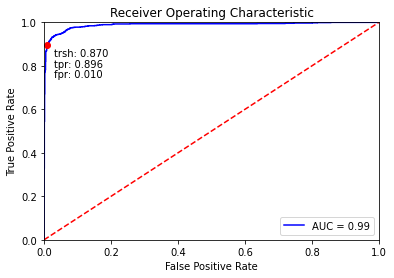

In [18]:
#optimal_idx = np.argmax(tpr - fpr)
optimal_idx = np.argmin(np.abs(fpr - 0.01))

optimal_threshold = threshold[optimal_idx]
print(optimal_threshold)

vis.plot_roc(roc_auc, fpr, tpr, optimal_threshold, optimal_idx)

## 5.2 Visualize Dataset and Sequence

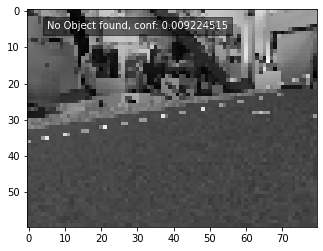

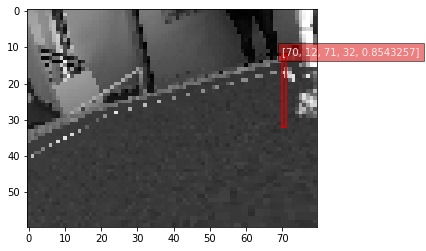

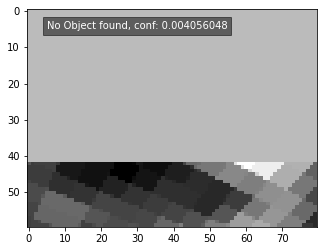

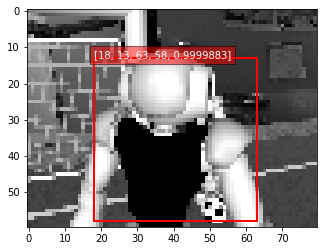

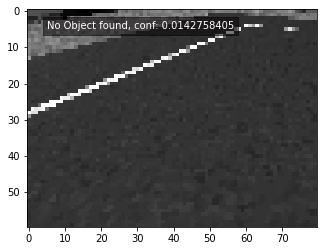

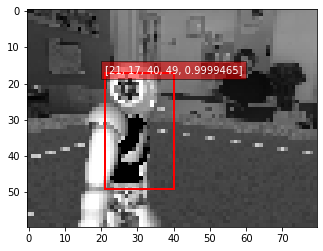

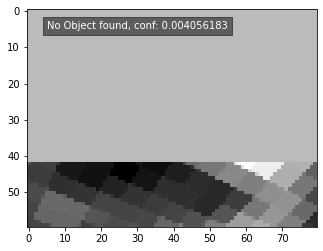

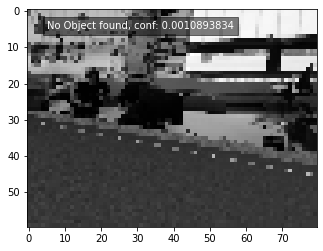

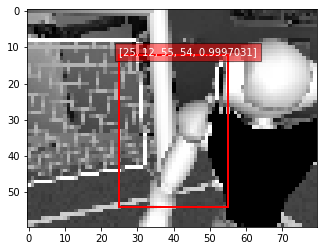

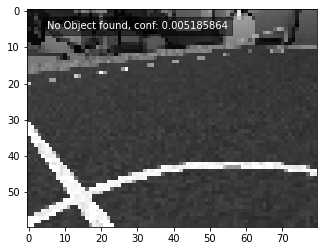

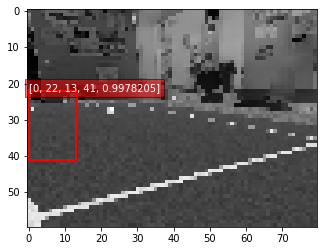

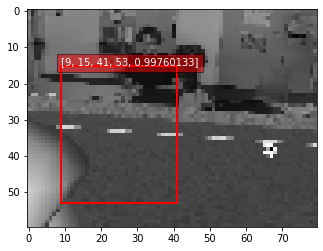

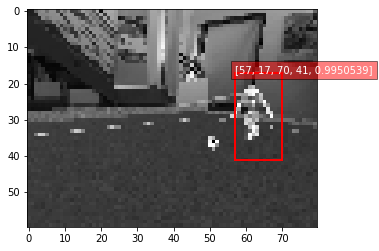

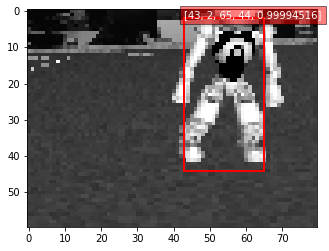

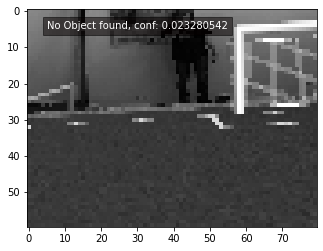

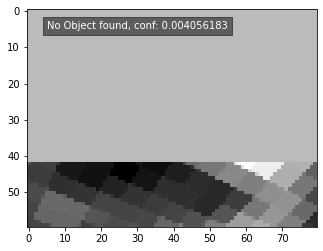

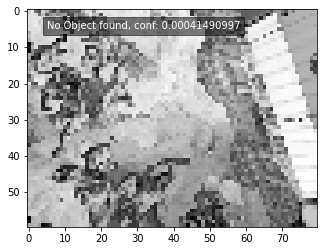

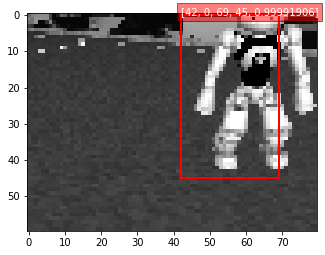

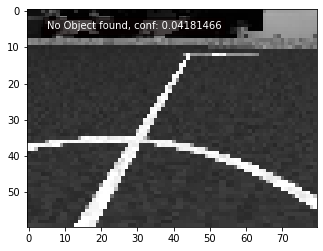

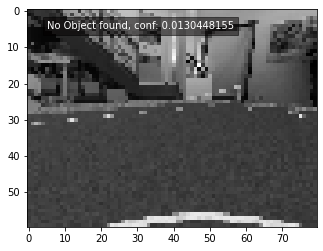

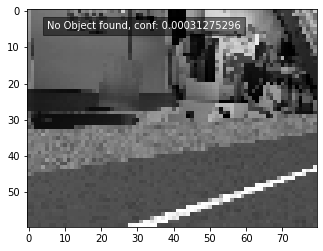

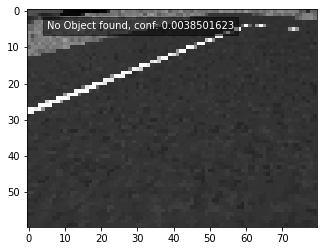

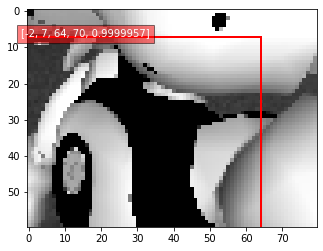

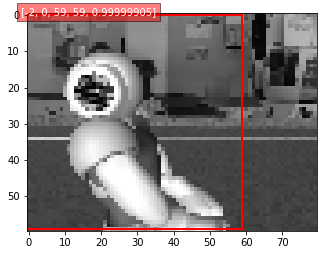

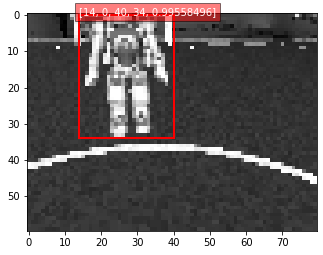

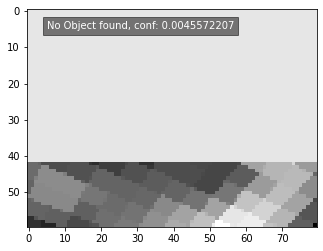

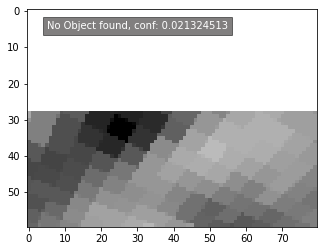

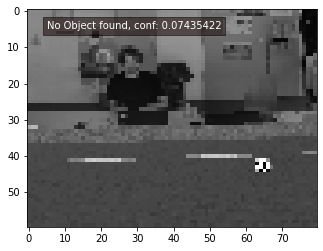

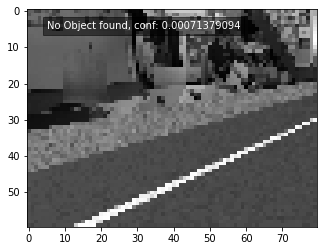

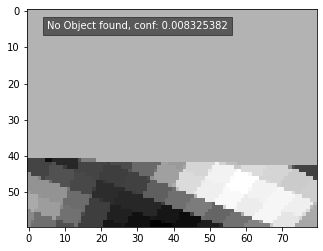

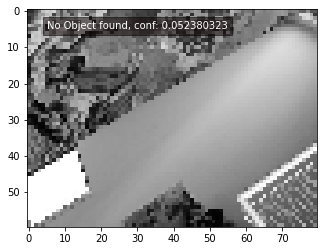

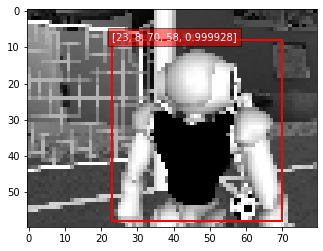

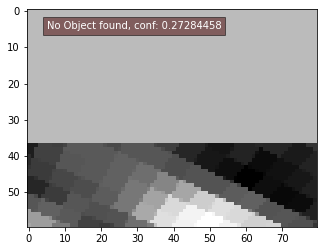

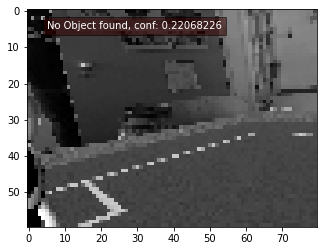

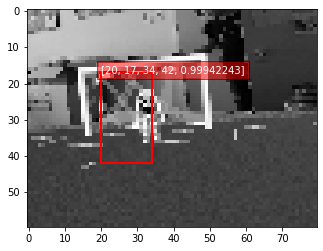

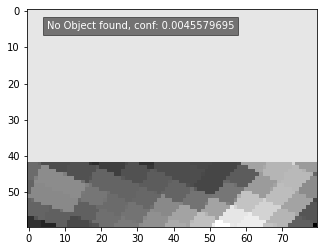

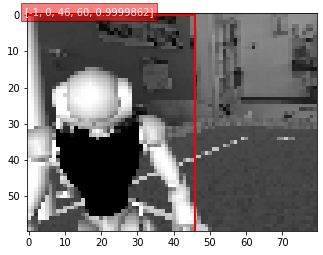

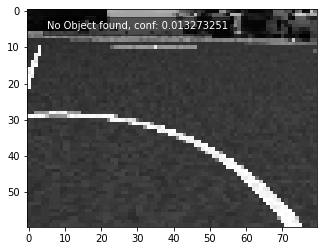

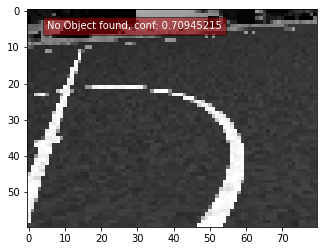

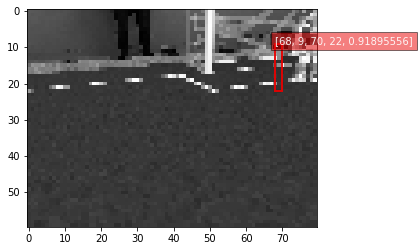

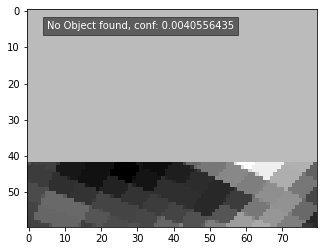

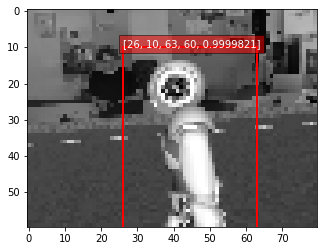

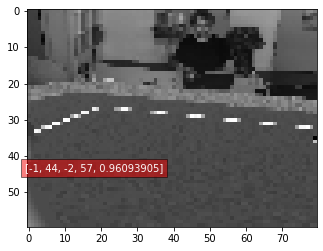

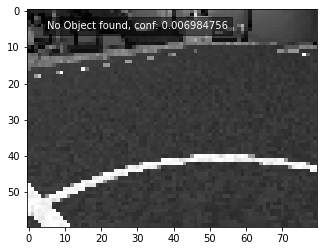

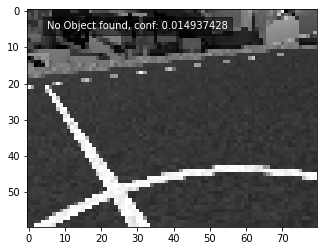

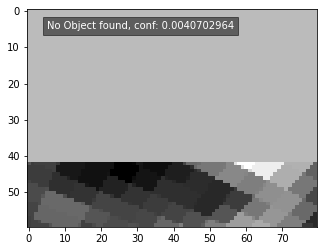

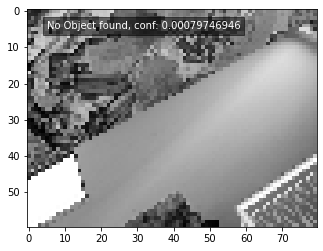

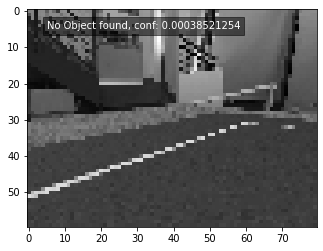

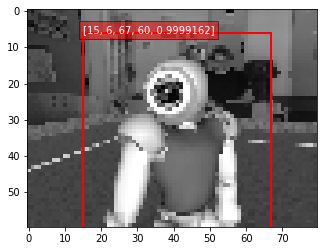

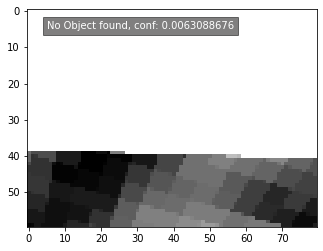

In [11]:
test_set = ds.load_tfrecord_dataset(ds.dataset_root_path + '1_4/', 'val.record').batch(1).take(50)
pred = model.predict(test_set)

i = 0
for image, label in test_set:
    if i > 50: break
    vis.plot_bbox(np.squeeze(image), util.unnormalize_bbox(pred[i], ds.target_size), conf_threshold=0.85)
    i += 1

In [23]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 80, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 60, 80, 24)   216         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 60, 80, 24)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 30, 40, 24)   5184        leaky_re_lu[0][0]                
_______________________________________________________________________________________

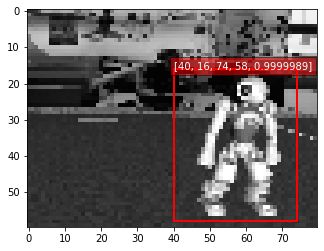

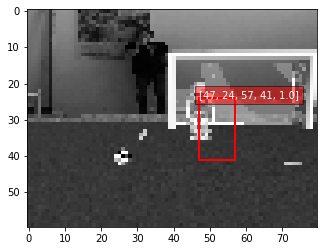

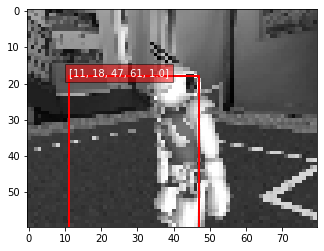

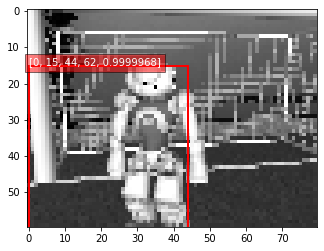

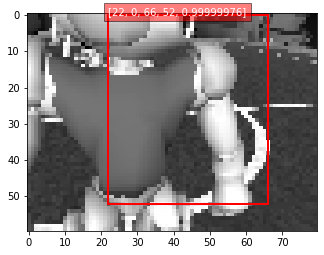

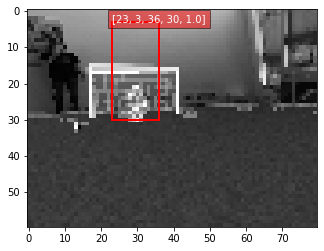

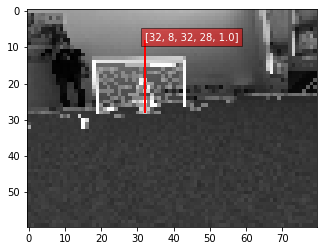

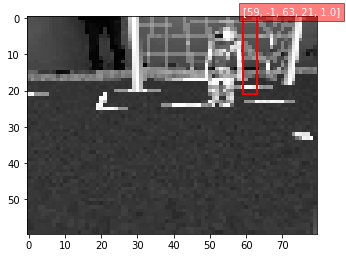

In [32]:
img_paths = ['upper_126910.png', 'upper_148200.png', 'upper_159180.png', 'upper_168360.png', 'upper_326080.png', 'upper_359980.png', 'upper_360490.png', 'upper_402960.png']

for img_path in img_paths:
    img = ds.parse_image(img_path, 'E:/datasets/simulator/2_3/images/')
    pred = model.predict(np.expand_dims(img * 255.0, axis=0))
    #pred = model.predict(np.expand_dims(img, axis=0))
    vis.plot_bbox(np.squeeze(img), util.unnormalize_bbox(pred[0], ds.target_size), conf_threshold=0.85)

# 6. Predict Distances in a Sequence

Hier wird ein trainiertes RandomForest Model geladen, welches anhand der BBOX Koordinaten eine Distanz schätzt. (s. 'distance_trainer.ipynb')

Für die gegebene Sequenz werden erstmal die echten Distanzen der Sequenz berechnet (mit den gegebenen Absouluten Positionen der Naos)
Danach mit dem RandomForest die geschätzten Distanzen.

Beide Datenreihen werden schließlich zusammen mit Bild und BBOX Visualisiert und in eine CSV Tabelle geschrieben

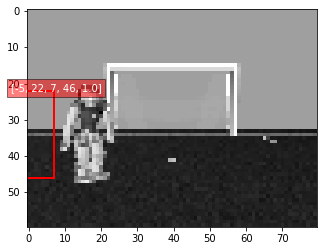

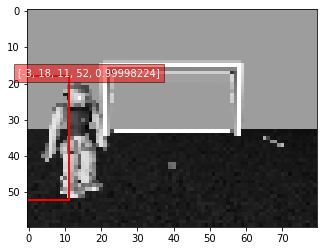

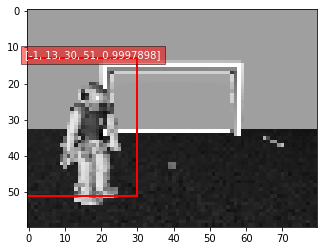

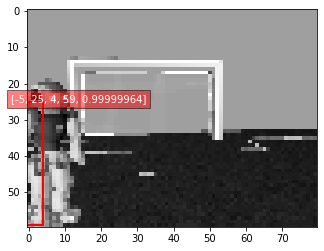

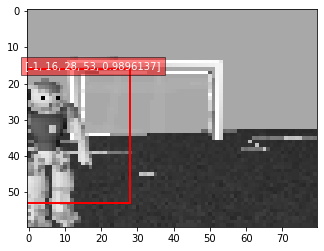

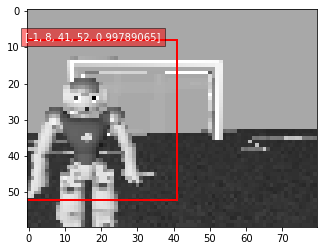

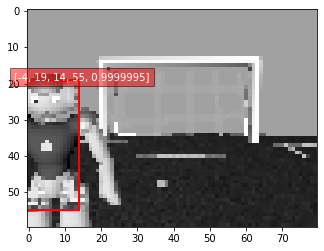

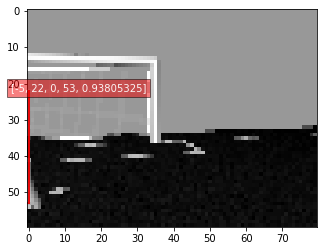

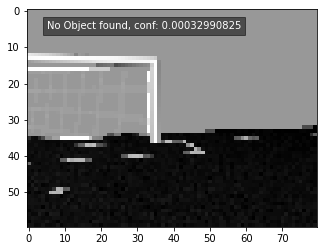

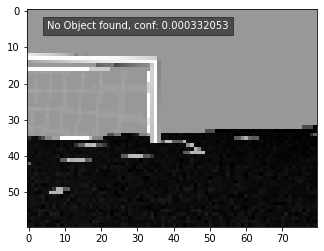

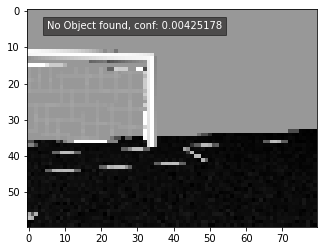

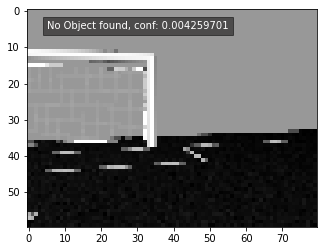

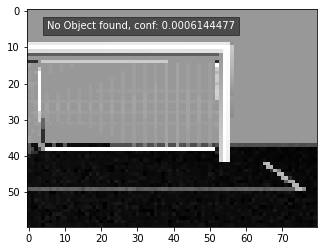

In [29]:
#from joblib import dump, load
#dist_pred = load(models_path + 'distance_predictor.joblib')
distances = []
SEQ_PATH = 'E:/datasets/sequenzen/unsere/sequence4/'
folder = SEQ_PATH + 'imagesUpper/'

# Load Data
#seq_raw_data = pd.read_csv(SEQ_PATH + 'SequenceFileOfWorldModel0.csv', sep=r'\s*,\s*',)
#data = seq_raw_data[['SequenceFileOfWorldModel0.csv','X-Pos NAO', 'Y-Pos NAO', 'Gegenspieler voraus (X-Pos)', 'Gegenspieler voraus (Y-Pos)']]
#data_dist = data.copy()

# Calculate distance
#distance_func = lambda p, q: np.linalg.norm(q - p)
#data_dist['distanz'] = data_dist.apply(lambda row: distance_func(np.array([row['Gegenspieler voraus (X-Pos)'], row['Gegenspieler voraus (Y-Pos)']]), np.array([row['X-Pos NAO'], row['Y-Pos NAO']])), axis=1)

# Visualize
for i in range(1, 14):
    img = ds.parse_image('U' + str(i).zfill(2) + '.png', folder)
    img = np.expand_dims(img * 255.0, axis=0)
    #img = np.expand_dims(img, axis=0)
    pred = model.predict(img)
    #dist = dist_pred.predict(pred)
    #print('Real: ' + str(data_dist['distanz'].iloc[i-1]))
    #print('Pred: ' + str(*dist))
    #distances.append(*dist)

    vis.plot_bbox(np.squeeze(img), util.unnormalize_bbox(pred[0], ds.target_size), conf_threshold=0.85)

#data_dist['pred_distanz'] = distances

In [29]:
# Load Data
seq_raw_data = pd.read_csv(SEQ_PATH + 'SequenceFileOfWorldModel0.csv', sep=r'\s*,\s*',)

# Write Distances to CSV
seq_raw_data['Gegenspieler Distanz'] = data_dist['distanz']
seq_raw_data['Gegenspieler Predicted Distanz'] = data_dist['pred_distanz']
seq_raw_data.to_csv(tables_path + 'SequenceFileOfWorldModel0_predictions.csv', index=False)
print(seq_raw_data)

    SequenceFileOfWorldModel0.csv    X-Pos NAO   Y-Pos NAO  Sichtwinkel NAO  \
0                               1 -1002.538818    0.740017      -179.996628   
1                               2 -1199.998047   -0.001736      -179.996628   
2                               3 -1199.998047   -0.001739      -179.996628   
3                               4 -1415.287720    2.077102       175.002731   
4                               5 -1415.287720    2.077088       175.002731   
5                               6 -1415.287720    2.077088       175.002731   
6                               7 -1615.417847  199.390762      -174.997421   
7                               8 -1614.696289  204.700699       165.002563   
8                               9 -1614.696289  204.700684       165.002563   
9                              10 -1614.696289  204.700684       165.002563   
10                             11 -1914.696289  304.700745       165.002563   
11                             12 -1914.696289  304.